# Imports e montagem (storage)

In [1]:
from google.colab import drive

drive.mount('/gdrive')

Mounted at /gdrive


In [2]:
import os
import cv2
import matplotlib.pyplot as plt
import numpy as np

from cv2.dnn import DetectionModel
from matplotlib import ft2font

In [3]:
path_dir_work ='/gdrive/My Drive/code'

os.chdir(path_dir_work)

# Classes

## Frame

In [4]:
class ObjectFrame:
  """
    Classe de definição de objetos contidos em um frame.
    Definições: rótulo, índice de confiança, coordenadas (box).
  """

  def __init__(self, 
               labels: set[str],
               confidence: float,
               location: tuple[tuple[int, int], tuple[int, int]]) -> None:
    
    self.labels = labels
    self.__confidence = confidence
    self.__location = location

  def get_labels(self) -> set[str]:
    return self.labels

  def get_label(self) -> str:
    return '+'.join(self.labels)

  def get_confidence(self) -> float:
    return self.__confidence

  def get_location(self) -> tuple[tuple[int, int], tuple[int, int]]:
    return self.__location

In [5]:
class FrameData:
  """
    Classe que define os atributos de um frame.
    Definiçoẽs: matriz de píxeis e objetos contidos.
  """

  def __init__(self, img: np.array,
               objects_detected: list[ObjectFrame]) -> None:
    self.__img = img
    self.__objects_detected = objects_detected
  
  def get_img(self) -> np.array:
    return self.__img

  def get_objects_detected(self) -> list[ObjectFrame]:
    return self.__objects_detected

## Construção dos "boxes"

In [6]:
# Classes para construção dos frames com as marcações dos objetos. 

class FrameMarkedBuilder:
  """
    Classe base para construção dos frames "marcados".
  """

  def __init__(self,
               font_type: int,
               font_scale: int,
               color: tuple[int, int, int],
               thickness: int) -> None:
    
    self.__font_type = font_type
    self.__font_scale = font_scale
    self.__color = color
    self.__thickness = thickness

  def get_image(self, frame: FrameData) -> np.array:
    return self.__drawing_boxes(frame)

  def get_font_type(self) -> int:
    return self.__font_type

  def get_font_scale(self) -> int:
    return self.__font_scale

  def get_color(self) -> tuple[int, int, int]:
    return self.__color

  def get_thickness(self) -> int:
    return self.__thickness

  def __drawing_boxes(self, frame: FrameData) -> np.array:
    img_cp = frame.get_img().copy()

    for obj in frame.get_objects_detected():
      start_posi, shape = obj.get_location()

      cv2.rectangle(img_cp, start_posi + shape, (0, 255, 0), 3)
      
      cv2.putText(img_cp, 
                  obj.get_label(),
                  (start_posi[0] + 15, start_posi[1] + 15),
                  self.get_font_type(),
                  self.get_font_scale(),
                  self.get_color(),
                  self.get_thickness())
      
    return img_cp


class UnchangedFrameMarkedBuilder(FrameMarkedBuilder):
  """
    Classe base para construção dos frames "marcados" de forma comum.
  """

  def __init__(self,
               font_type: int,
               font_scale: int,
               color: tuple[int, int, int],
               thickness: int) -> None:
    
    super().__init__(font_type, font_scale, color, thickness)


class FusionFrameMarkedBuilder(FrameMarkedBuilder):
  """
    Classe base para construção dos frames "marcados" com minização de "boxes".
  """

  def __init__(self,
               font_type: int,
               font_scale: int,
               color: tuple[int, int, int],
               thickness: int) -> None:
    
    super().__init__(font_type, font_scale, color, thickness)

  def get_image(self, frame: FrameData) -> np.array:
    img_cp = frame.get_img().copy()
    objs_detected = frame.get_objects_detected()

    if len(objs_detected) == 0:
      return img_cp

    new_objects: list[ObjectFrame] = []
    new_objects.append(objs_detected[0])

    for obj in objs_detected[1:]:
      
      labels = obj.get_labels()
      start_p, shape = obj.get_location()

      list_rm: list[ObjectFrame] = []

      for n_obj in new_objects:
        n_start_p, n_shape = n_obj.get_location()
        
        obj_line_x = (start_p[0], start_p[0] + shape[0])
        n_obj_line_x = (n_start_p[0], n_start_p[0] + n_shape[0])

        obj_line_y = (start_p[1], start_p[1] + shape[1])
        n_obj_line_y = (n_start_p[1], n_start_p[1] + n_shape[1])

        if (self.__is_between(obj_line_x, n_obj_line_x) 
            and self.__is_between(obj_line_y, n_obj_line_y)):
          
          labels = labels.union(n_obj.get_labels())
          start_p, shape = self.__get_max_box((start_p, shape),  n_obj.get_location())
          list_rm.append(n_obj)

      for r in list_rm:
        new_objects.remove(r)

      if start_p == obj.get_location()[0] and shape == obj.get_location()[1]:
        new_objects.append(obj)
      else:
        new_objects.append(ObjectFrame(labels, 1, (start_p, shape)))
      
    return super().get_image(FrameData(frame.get_img(), new_objects))

  def __get_max_box(self, obj_1: tuple[tuple[int, int], tuple[int, int]],
                      obj_2: tuple[tuple[int, int], tuple[int, int]]
                     ) -> tuple[tuple[int, int], tuple[int, int]]:

    start_p1, shape1 = obj_1[0], obj_1[1]
    start_p2, shape2 = obj_2[0], obj_2[1]

    end_p1 = (start_p1[0] + shape1[0], start_p1[1] + shape1[1])
    end_p2 = (start_p2[0] + shape2[0], start_p2[1] + shape2[1])

    new_start_p = (min(start_p1[0], start_p2[0]), min(start_p1[1], start_p2[1]))
    new_shape = (max(end_p1[0], end_p2[0]) - new_start_p[0], max(end_p1[1], end_p2[1]) - new_start_p[1])

    return (new_start_p, new_shape)
    
  def __is_between(self, obj_1: tuple[int, int], obj_2: tuple[int, int]) -> bool:
    return (obj_1[0] <= obj_2[0] <= obj_1[1] 
            or obj_1[0] <= obj_2[1] <= obj_1[1]
            or obj_2[0] <= obj_1[0] <= obj_2[1] 
            or obj_2[0] <= obj_1[1] <= obj_2[1])

## Rede

In [7]:
class DetectionNetwork:

  def __init__(self, model: DetectionModel,
               object_class: list[str],
               input_size: tuple[int, int],
               scale: float,
               input_mean: tuple[float, float, float],
               input_swap_rb = True) -> None:
    
    self.__model = model
    self.__model.setInputSize(input_size[0], input_size[1])
    self.__model.setInputScale(scale)
    self.__model.setInputMean(input_mean)
    self.__model.setInputSwapRB(input_swap_rb)
    self.__object_class = object_class

  def detect_objects(self, img: np.array, threshold=0.5) -> FrameData:
    class_index, confidences, boxes = self.__model.detect(img, threshold)
    list_objects: list[ObjectFrame] = []

    for dt in zip(class_index, confidences, boxes):
      label = self.__object_class[dt[0] - 1]
      conf = dt[1]

      start_posi = (dt[2][0], dt[2][1])
      shape = (dt[2][2], dt[2][3])

      list_objects.append(ObjectFrame({label}, conf, (start_posi, shape)))

    return FrameData(img.copy(), list_objects)

  def __str__(self) -> str:
    class_o = ', '.join(self.__object_class)
    return f'Class Detection: {class_o}'

# Instância: Rede

## Definição das Variaveis 

In [14]:
# Diretórios dos dados

dir_train_name = 'train'

dir_test_name = 'tests'

In [15]:
# Arquivos de treinamento

# Rótulos: classes dos objetos 
filename_yolo_class = 'yolo3.txt'

# Configuração da Rede
filename_coco_network_conf = 'ssd_mobilenet_v3_large_coco.pbtxt' 

# Grafo de inferência
filename_frozen_graph = 'frozen_inference_graph.pb'

In [16]:
# Definições de resoluçao da rede: imagems

input_dimension = 320
size_input = 127.5

## Leitura de Dados e Criação da Rede

In [17]:
class_yolo = (open(f'{dir_train_name}/{filename_yolo_class}').read().split('\n'))[:-1]

In [18]:
network = DetectionNetwork(cv2.dnn_DetectionModel(
      f'{dir_train_name}/{filename_frozen_graph}',
      f'{dir_train_name}/{filename_coco_network_conf}'
    ),
    class_yolo,
    (input_dimension, input_dimension),
    1 / size_input,
    (size_input, size_input, size_input))

In [20]:
network.__str__()

'Class Detection: person, bicycle, car, motorbike, aeroplane, bus, train, truck, boat, traffic light, fire hydrant, stop sign, parking meter, bench, bird, cat, dog, horse, sheep, cow, elephant, bear, zebra, giraffe, backpack, umbrella, handbag, tie, suitcase, frisbee, skis, snowboard, sports ball, kite, baseball bat, baseball glove, skateboard, surfboard, tennis racket, bottle, wine glass, cup, fork, knife, spoon, bowl, banana, apple, sandwich, orange, broccoli, carrot, hot dog, pizza, donut, cake, chair, sofa, pottedplant, bed, diningtable, toilet, tvmonitor, laptop, mouse, remote, keyboard, cell phone, microwave, oven, toaster, sink, refrigerator, book, clock, vase, scissors, teddy bear, hair drier, toothbrush'

# Experimentos

## Park

In [24]:
img = cv2.imread(f'{dir_test_name}/central-park.jpg')
frame = network.detect_objects(img, 0.5)

make_frame = UnchangedFrameMarkedBuilder(cv2.FONT_HERSHEY_PLAIN, 2, (0, 0, 255), 3)
img_mod = make_frame.get_image(frame)

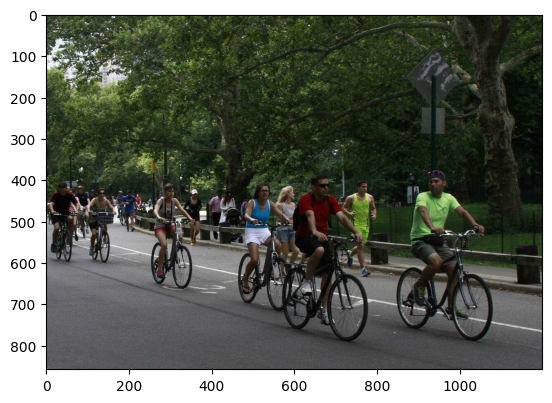

In [25]:
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))

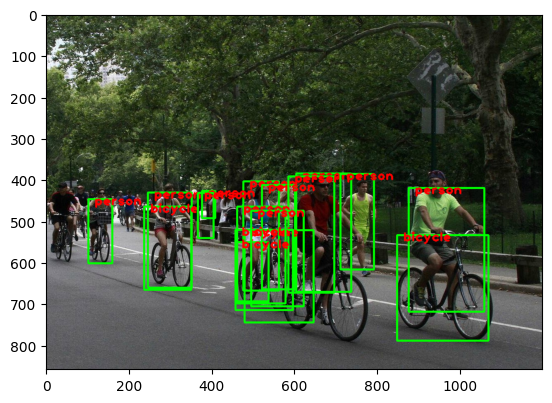

In [26]:
plt.imshow(cv2.cvtColor(img_mod, cv2.COLOR_BGR2RGB))

## Traffic

In [28]:
img = cv2.imread(f'{dir_test_name}/traffic.jpeg')
frame = network.detect_objects(img, 0.5)

make_frame = UnchangedFrameMarkedBuilder(cv2.FONT_HERSHEY_PLAIN, 2, (0, 0, 255), 3)
img_mod = make_frame.get_image(frame)

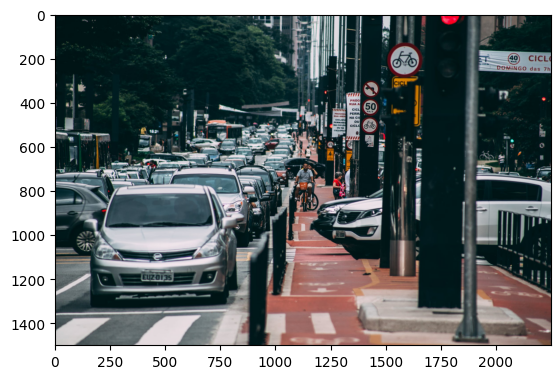

In [29]:
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))

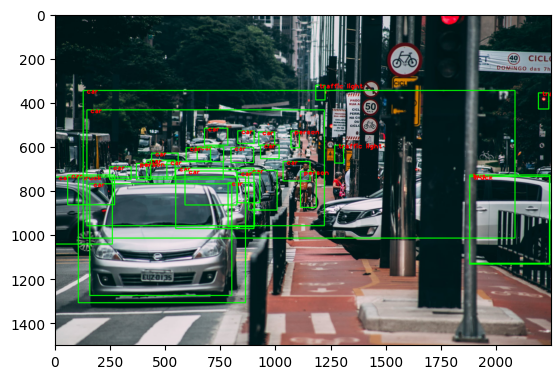

In [30]:
plt.imshow(cv2.cvtColor(img_mod, cv2.COLOR_BGR2RGB))

## Car

In [33]:
img = cv2.imread(f'{dir_test_name}/car.jpg')
frame = network.detect_objects(img, 0.5)

make_frame = UnchangedFrameMarkedBuilder(cv2.FONT_HERSHEY_PLAIN, 2, (0, 0, 255), 3)
img_mod = make_frame.get_image(frame)

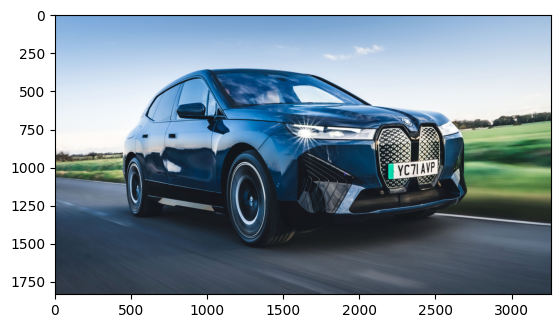

In [34]:
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))

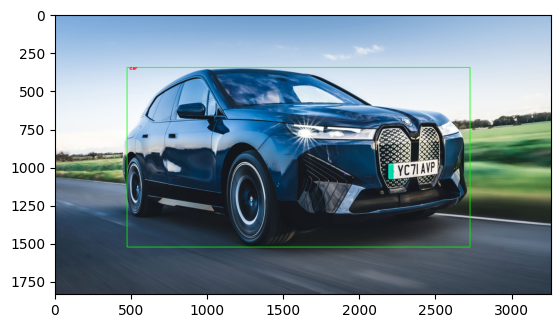

In [35]:
plt.imshow(cv2.cvtColor(img_mod, cv2.COLOR_BGR2RGB))